## <b><u> Time series Forecasting for Favorita Store Sales </b></u>
   - `In this project we will be building a regression model and understand hw to use it`
   - `We will also examine the correlation coeffcient,multiple regression  and logisti regression methods`
   - `using logistic regression we will be able to estimate the probability of the business success over give period of time`
   - `finally; develop a time series Analysis`



### <u><b><i> Description </u></b></i>
` As a data scientist, I will be looking at a favorita  grocery stores data  and predict a little over time based on th sales performance previously... </ `
 - The Favorita Grocery Sales Forecasting competition is a time series forecasting competition hosted by the Favorita Food Markets Association. The goal is to predict the sales of various products sold in multiple locations over time. The dataset provided includes sales data, promotions, and other relevant features.
 - `The dataset includes;;;;;;;;;;;;`
- train.csv: includes store_number, family, onpromotion and target sales
- test.csv: same as train.csv(predict sales data)
- transaction.csv: date,store_number,transation 
- sample_submission.csv: 
- stores.csv: store metabase including city, state,type and cluster
 - oils.csv: daily oil price
 - holidays_events.csv: Holidays events
 ## Questions
 1. Is the train dataset complete (has all the required dates)?
 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)
 3. Compare the sales for each month across the years and determine which month of which year had the highest sales. 
 4. Did the earthquake impact sales?
 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
 6. Are sales affected by promotions, oil prices and holidays
 7. What analysis can we get from the date and its extractable features?
 8. Which product family and stores did the promotions affect.
 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
 ### <u><b><i> HYPOTHESIS</u></b></i>
Null hypothesis;`The type of holiday does not have any significance on the increase of sales`
Alternative hypothesis; `The type of holiday do have significant on the increase of sales`

In [122]:
#installing pyodbc & python-dotenv
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sn
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource
import mplcursors
from bokeh.io import output_notebook


In [123]:
#load environment variable from .env file
environment_variable =dotenv_values('.env')
#we get the credentails  fro th env file
database=environment_variable.get('DATABASE')
server=environment_variable.get('SERVER')
username=environment_variable.get('USERNAME')
password=environment_variable.get('PASSWORD')
# Establish connection
connection_string= f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [124]:
#We need to use the connection method that is the pyodbc library
connection=pyodbc.connect(connection_string)

In [125]:
#SQL query to get the dat 
query_oil="SELECT* FROM dbo.oil"
query_stores="SELECT* FROM dbo.stores"
query_holidays_events="SELECT* FROM dbo.holidays_events"
df_oil=pd.read_sql(query_oil,connection)
df_stores=pd.read_sql(query_stores,connection)
df_holidays_events=pd.read_sql(query_holidays_events,connection)
# Close the connection





In [126]:
#load csv data set
df_submission=pd.read_csv("sample_submission (1).csv")
df_test=pd.read_csv("test (1).csv")
df_transaction=pd.read_csv("transactions.csv")



In [127]:
##sql EDA
#summary statisitcs for th column
oil_sum=df_oil.describe().T
event_sum=df_holidays_events.describe().T
store_sum=df_stores.describe().T
##result
print("holiday summary:")
display(event_sum)
print('*'*40)
print("Store Summary:")
display(store_sum)
print('$'*40)
print("oil summary:")
display(oil_sum)
print('-'*40)




holiday summary:


,count,unique,top,freq
date,350,312,2014-06-25,4
type,350,6,Holiday,221
locale,350,3,National,174
locale_name,350,24,Ecuador,174
description,350,103,Carnaval,10
transferred,350,2,False,338


****************************************
Store Summary:


,count,mean,std,min,25%,50%,75%,max
store_nbr,54.0,27.500000,15.732133,1.0,14.25,27.5,40.75,54.0
cluster,54.0,8.481481,4.693395,1.0,4.00,8.5,13.00,17.0


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
oil summary:


,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1175.0,67.714366,25.630476,26.190001,46.405001,53.189999,95.66,110.620003


----------------------------------------


In [128]:
#missing values
print("event missing values:")
events_missing=df_holidays_events.isnull().sum()
display(events_missing)
print('*'*40)
print("oil missing values:")
oil_missing=df_oil.isnull().sum()
display(oil_missing)
print('*'*40)
print("store missing values:")
store_missing=df_stores.isnull().sum()
display(store_missing)
print('*'*40)

event missing values:


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

****************************************
oil missing values:


date           0
dcoilwtico    43
dtype: int64

****************************************
store missing values:


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

****************************************


In [129]:
print("holiday shape:")
print('*'*40)
holiday_shape=df_holidays_events.shape
print("rows:",holiday_shape[0])
print("column",holiday_shape[1])
#oilshape
print("oil shape:")
print('*'*40)
oil_shape=df_oil.shape
print("rows:",oil_shape[0])
print("column",oil_shape[1])

#store shape
print("store shape:")
print("<>"*40)
store_shape=df_stores.shape
print("rows:",store_shape[0])
print("column:",store_shape[1])



holiday shape:
****************************************
rows: 350
column 6
oil shape:
****************************************
rows: 1218
column 2
store shape:
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
rows: 54
column: 5


#### <i><u> SCV EDA </u></i>

In [130]:
## SCV SUMMARY STATTISITCS 
transaction_summary= df_transaction.describe().T 
#Test summary
test_summary=df_test.describe().T

#Submission summary
submission_summary=df_submission.describe().T

#print summary
print("transaction summary:")
display(transaction_summary)
print("*"*50)

print("submission summary:")
display(submission_summary)
print("*"*50)

print("test summary:")
display(test_summary)



transaction summary:


,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


**************************************************
submission summary:


,count,mean,std,min,25%,50%,75%,max
id,28512.0,3015143.5,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
sales,28512.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0


**************************************************
test summary:


,count,mean,std,min,25%,50%,75%,max
id,28512.0,3.015144e+06,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
store_nbr,28512.0,2.750000e+01,15.586057,1.0,14.00,27.5,41.00,54.0
onpromotion,28512.0,6.965383e+00,20.683952,0.0,0.00,0.0,6.00,646.0


In [131]:
#shape check
print(f"transaction rows:{df_transaction.shape}")
print(f"submission shape:{df_submission.shape}")
print(f"test shape:{df_test.shape}")

transaction rows:(83488, 3)
submission shape:(28512, 2)
test shape:(28512, 5)


In [132]:
#Missing values
print(f"transcaction missing values:{df_transaction.isna().sum()}")
print(f"submission missing data{df_submission.isna().sum()}")
print(f"test missing values:{df_test.isna().sum()}")



transcaction missing values:date            0
store_nbr       0
transactions    0
dtype: int64
submission missing dataid       0
sales    0
dtype: int64
test missing values:id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


#### <i><u> handling missing values</u></i>

` for this case we have value mising on the dcoil on the data file and we will use back fill method because;`

- because the data is a time sries  and missing values is due to temporary gaps like holidays or weekends 
- we will assume the secondly recorded values remains valid

In [133]:
#find missing values in the oil data file
df_oil['dcoilwtico']=df_oil['dcoilwtico'].fillna(method='backfill')
df_oil.isnull().sum()
#print(f"filling missing data:{df_oil['dcoilwtico'].fillna( method='backfill')}")

date          0
dcoilwtico    0
dtype: int64

In [134]:
df_train=pd.read_csv("train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [135]:
##change train data date type from object to dat type
#check date completeness
print (f"min_date;{df_train['date'].min()},max date:{df_train['date'].max()}")
print("   "*60)
expected_date= pd.date_range(start=df_train['date'].min(), end=df_train['date'].max())
mising_date=expected_date[~expected_date.isin(df_train['date'])]

if len(mising_date)==0:
    print("complete")
else:
    print(f"missing date:{mising_date}")



min_date;2013-01-01,max date:2017-08-15
                                                                                                                                                                                    
missing date:DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


Train data has chrismas holiday as the  missing date

In [136]:
# covert dates from object to datetim
df_train['date']=pd.to_datetime(df_train['date'])

#complete the missind dateby creating an index of missing dates
missing_dates=pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

#add the missing dates to the dataframe
missing_data=pd.DataFrame({'date':missing_dates})
#concat
df_train=pd.concat([df_train,missing_data],ignore_index=True)

#sort the dataframe by date

df_train.sort_values(by='date', inplace=True)



In [137]:
#set the date type in te csv file as  date type
df_test=pd.read_csv("test (1).csv",parse_dates=['date'])
df_train=pd.read_csv("train.csv",parse_dates=['date'])
df_transaction=pd.read_csv("transactions.csv",parse_dates=['date'])
df_submission=pd.read_csv("sample_submission (1).csv")

### <b><u> Checking for stationarity</u></b>
    - checking for stationarity in a time series column[date] is very necessary for understanding the statistical propertes of the dataset and dtermine in the appropriate model technidue to use
A time series is statinary if the statisitical properties [mean,variance add covariance] remain consant over time
- ARIMA and SARIMA models assume stationarity 
non-stationary data  can lead to invalid results

In [138]:
# Define the function to check stationarity
def check_stationarity(df, column, title=''):
    """
    Checks stationarity of a numeric time series using the Augmented Dickey-Fuller test.
    """
    print(f"\nStationarity check for: {title}")
    
    # Validate if the column exists in the DataFrame
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in the DataFrame.")
        return
    
    # Drop missing values in the selected column
    data = df[column].dropna()
    
    # Perform the ADF test
    result = adfuller(data)
    
    # Print the test results
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    
    # Check the p-value to decide stationarity
    if result[1] <= 0.05:
        print("Reject null hypothesis (data is stationary).")
    else:
        print("Fail to reject null hypothesis (data is non-stationary).")

# Apply the stationarity check on the numeric column (e.g., 'transaction_data')
check_stationarity(df_transaction, column='transactions', title='Transaction Data')


Stationarity check for: Transaction Data
ADF Statistic: -16.5742
p-value: 0.0000
Critical Values: {'1%': -3.4304283896674406, '5%': -2.8615746469290144, '10%': -2.566788441361157}
Reject null hypothesis (data is stationary).


### Fit ARIMA Model
ARIMA REQUIRES 3 PARAMETERS:
- p(AR):Autoregressive terms
- d(I):Differencing order
- q(MA): Moving Average

Here we will use first order differencing to make the data stationary


In [21]:
## differencing the dta

auto_model=auto_arima(
    df_transaction['transactions'],
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=97.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1370457.889, Time=1.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1362169.673, Time=1.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1357240.650, Time=5.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1370455.889, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=54.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1354840.083, Time=9.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1354005.374, Time=20.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1353905.362, Time=49.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1354817.520, Time=29.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1353565.832, Time=77.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=128.39 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1347870.688, Time=118.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=132.94 sec


KeyboardInterrupt: 

In [20]:
p, d, q =auto_model.order

# Fit ARIMA model
model=ARIMA(df_transaction['transactions'],order=(p, d, q))
arima_result =model.fit()


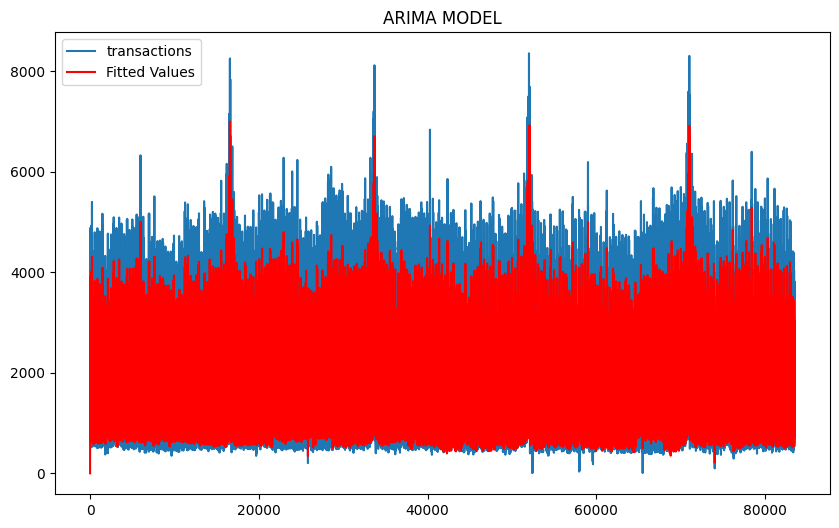

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df_transaction['transactions'],label='transactions')
plt.plot(arima_result.fittedvalues,label='Fitted Values',color='red')
plt.legend()
plt.title('ARIMA MODEL')
plt.show()

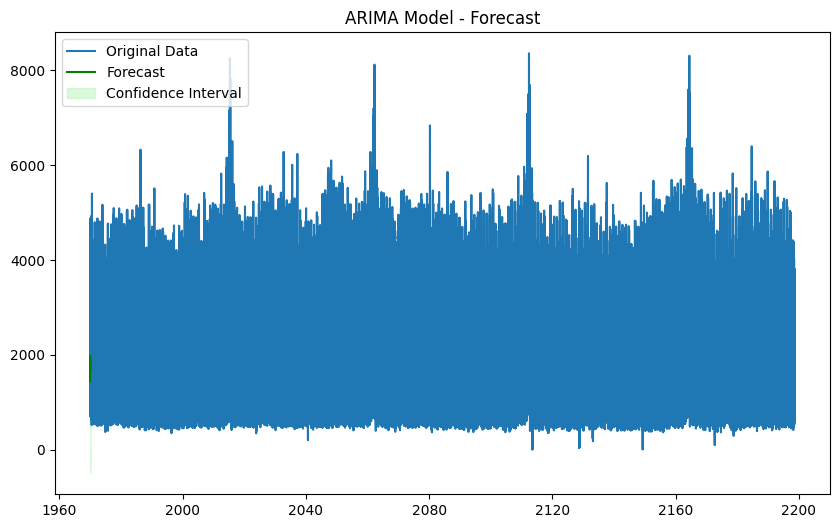

In [22]:
# Forecast future values (e.g., next 10 periods)
forecast_steps = 10
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=df_transaction.index[-1],
    periods=forecast_steps + 1,  # Include the starting point
    freq='D'  # Adjust frequency as needed
)[1:]

# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot original data and forecasts
plt.figure(figsize=(10, 6))
plt.plot(df_transaction['transactions'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(
    forecast_index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightgreen', alpha=0.3, label='Confidence Interval'
)
plt.legend()
plt.title('ARIMA Model - Forecast')
plt.show()

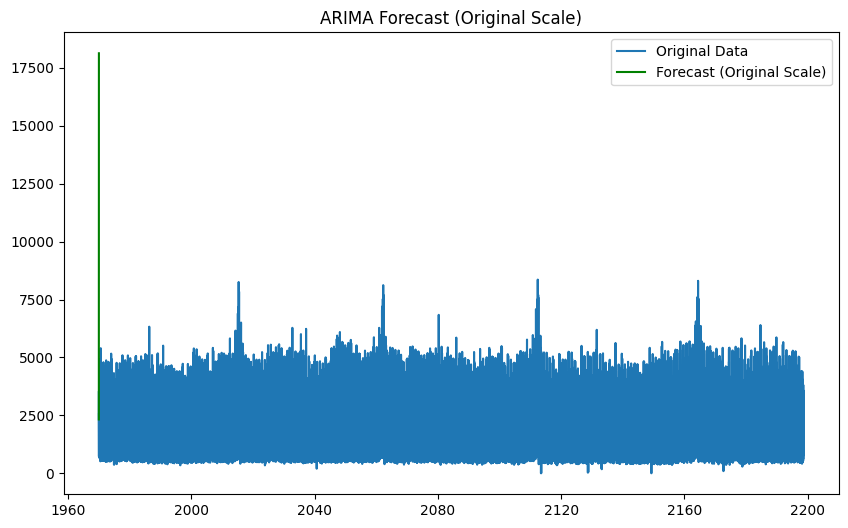

In [23]:
# Add the last observed value to forecasted differences
forecast_original_scale = forecast_values.cumsum() + df_transaction['transactions'].iloc[-1]

# Plot the forecasts in the original scale
plt.figure(figsize=(10, 6))
plt.plot(df_transaction['transactions'], label='Original Data')
plt.plot(forecast_index, forecast_original_scale, label='Forecast (Original Scale)', color='green')
plt.legend()
plt.title('ARIMA Forecast (Original Scale)')
plt.show()

## <b><i> CRUDE OIL PRICES CHANGES OVER TIME</i></b>

In [139]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [140]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


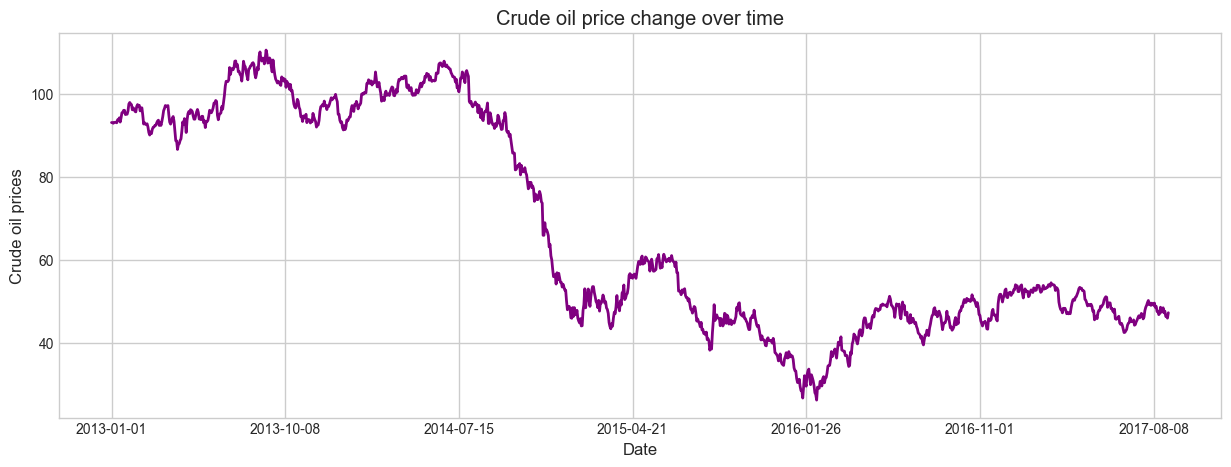

In [141]:
df_oil.set_index("date")
df_oil.plot(x="date",y="dcoilwtico",color="purple",legend=False,figsize=(15,5))
plt.title("Crude oil price change over time")
plt.xlabel("Date")
plt.ylabel("Crude oil prices")
plt.style.use('seaborn-v0_8-whitegrid')
# Add hover functionality
mplcursors.cursor(hover=True)

# Show plot
plt.show()



## FEATURING ENGINEERING
prepare the data for the ML; The process will involve extracting and transforming the ML Model

In [142]:
df_holidays_events['date']=pd.to_datetime(df_holidays_events['date'])
df_holidays_events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [143]:
df_oil['date']=pd.to_datetime(df_oil['date'])
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [144]:
df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [146]:
#merge the file
df_timeseries=df_train.merge(df_stores,on='store_nbr',how='inner')
df_timeseries=df_timeseries.merge(df_holidays_events,on='date',how='inner')
df_timeseries=df_timeseries.merge(df_oil,on='date',how='inner')
df_timeseries=df_timeseries.merge(df_transaction,on=['date','store_nbr'],how='inner')


>STEP 1: FEATURE TRANSFORMATION 
- 1.Scaling
- 2.Encoding categorical variables
- 3.Log Transormation
>STEP 2:FEATURE SCALING
- 1. remove redundant feature
- 2. statistical test
- 3. feature importance 
>STEP 3: FEATURE CREATION